Initial setup

In [2]:
import wosis
import pandas as pd
import metaknowledge as mk

In [3]:
# Helper functions for plotting
import wosis.analysis.plotting as wos_plot

# Analysis and search functions
from wosis.analysis import (preview_matches, search_records, keyword_matches, 
                            find_pubs_by_authors, preview_matches_by_keyword, get_unique_kw_titles,
                            remove_by_journals, remove_by_title)

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# This just helps make the plots look nicer
sns.set_style('darkgrid')
sns.set_context('paper', font_scale=2.0)

In [4]:
# Read in data from temporary cache file
query_id = "756d39801152fe5f5f4ad3a3df9b6a30"
RC = mk.RecordCollection("tmp/{}.txt".format(query_id))

expected_num_records = 15754
num_records = len(RC)

assert num_records == expected_num_records, \
    "Mismatch in number of records - expected {}, got {}".format(expected_num_records, num_records)

print("Corpora consists of", num_records, "Publications")

Corpora consists of 15754 Publications


In [5]:
corpora_df = wosis.rc_to_df(RC)

corpora_df, removed_pubs = wosis.constrain.remove_empty_DOIs(corpora_df)

Removing 1799 records with no DOIs


In [7]:
# Checking if expected paper is in corpora
corpora_df.loc[corpora_df['DOI'] == '10.1016/j.jocs.2015.08.008', :]

,AU,DE,DOI,SO,abstract,id,keywords,title,year
13489,"Feinberg, Jonathan|Langtangen, Hans Petter",uncertainty quantification|polynomial chaos ex...,10.1016/j.jocs.2015.08.008,JOURNAL OF COMPUTATIONAL SCIENCE,the paper describes the philosophy design func...,WOS:000367774700005,,Chaospy: An open source tool for designing met...,2015


In [9]:
# Create a new metaknowledge collection
filtered_corpora = wosis.extract_recs(corpora_df.loc[:, 'id'], RC, name='Filtered Corpora')

<hr>

Run topic model

In [12]:
from wosis.analysis import find_topics

filtered_corpora_df = wosis.rc_to_df(filtered_corpora)
topic_results = find_topics(filtered_corpora_df, num_topics=5)

Topic 1: model water soil flow parameters sensitivity river data groundwater analysis
Topic 2: optimization design method shape topology sensitivity problem element finite analysis
Topic 3: energy cycle environmental life emissions production assessment waste impact lca
Topic 4: uncertainty model models stochastic data analysis method quantification parameter carlo
Topic 5: risk exposure assessment health cancer risks human flood probabilistic analysis


In [13]:
topic_pubs = {
    'model': topic_results.get_topic_by_id(1),
    # 'UA': topic_results.get_topic_by_id(8)
    # 'SA': topic_results.get_topic_by_id(20)
}

# len(topic_pubs['model']), len(topic_pubs['UA'])
len(topic_pubs['model'])

5022

In [14]:
# find paper of interest - see if it's still in the corpora
for i in range(1,26):
    topic_set = topic_results.get_topic_by_id(i)
    
    topic_recs = wosis.extract_recs(topic_set.loc[:, 'id'], RC, 'Topic of Interest')
    tmp_df = pd.DataFrame(topic_recs.forNLP(extraColumns=['DOI']))

    if len(tmp_df.loc[tmp_df["DOI"] == '10.1016/j.jocs.2015.08.008', :]) > 0:
        print("Found paper in topic", i)
        break

Found paper in topic 4


In [15]:
# topic_set.loc[:, ~topic_set.columns.isin(hide_columns)].head(10)

In [16]:
uc_model_topic = topic_results.get_topic_by_id(4)
uc_model_rc = wosis.extract_recs(uc_model_topic.loc[:, 'id'], RC, 'Topic of Interest')

In [17]:
ua_topic_df = wosis.rc_to_df(uc_model_rc)
ua_topic_df.loc[ua_topic_df["DOI"] == '10.1016/j.jocs.2015.08.008', :]

,AU,DE,DOI,SO,abstract,id,keywords,title,year
1815,"Feinberg, Jonathan|Langtangen, Hans Petter",uncertainty quantification|polynomial chaos ex...,10.1016/j.jocs.2015.08.008,JOURNAL OF COMPUTATIONAL SCIENCE,the paper describes the philosophy design func...,WOS:000367774700005,,Chaospy: An open source tool for designing met...,2015


<hr>

Plot journal trend of topic 1, see top publications by citation

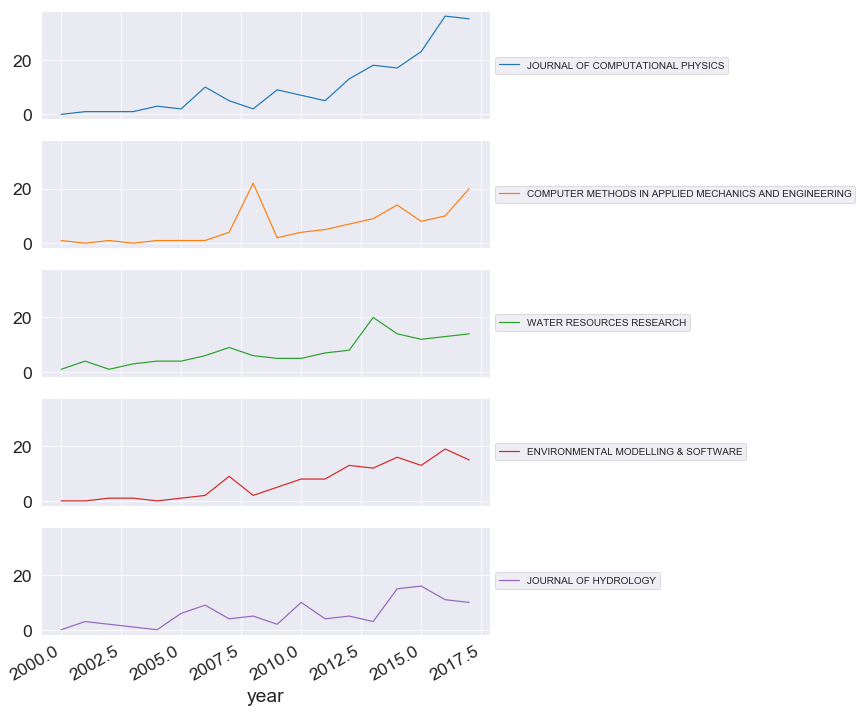

In [27]:
wos_plot.plot_journal_pub_trend(uc_model_rc, top_n=5, save_plot_fn='figs/uc_model_journal_pub_trend.png')

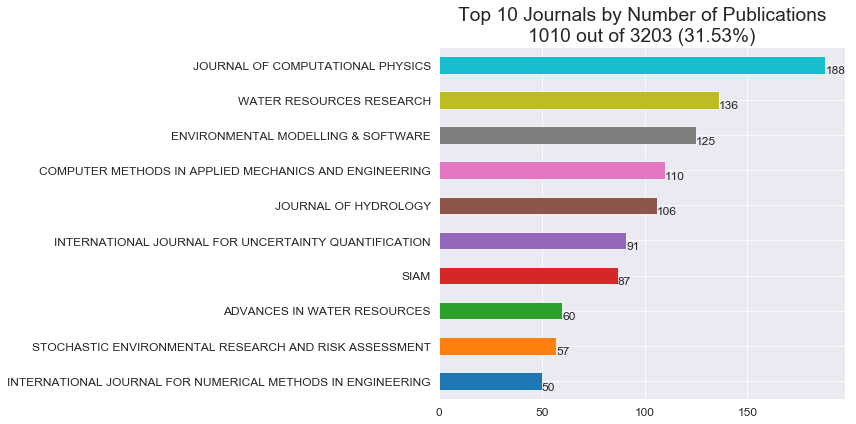

In [24]:
wos_plot.plot_pubs_per_journal(uc_model_rc, top_n=10, annotate=True, show_stats=True, save_plot_fn='uc_model_journal_pubs.png')

In [19]:
# These are the papers cited within the corpora
wosis.analysis.pub_citations(uc_model_rc).head()
#ideas: could take first 1000 by citation number, but higher citations would favour older papers.  Taking by year?
#or simply choose first 1000 matches?

,Citations
Publication,
"Xiu, DB, 2003, A new stochastic approach to transient heat conduction modeling with uncertainty, INTERNATIONAL JOURNAL OF HEAT AND MASS TRANSFER, 46, 4681, 39162035",655
"BEVEN, K, 1992, THE FUTURE OF DISTRIBUTED MODELS - MODEL CALIBRATION AND UNCERTAINTY PREDICTION, HYDROLOGICAL PROCESSES, 6, 279, 400138",645
"Saltelli, A, 1999, A quantitative model-independent method for global sensitivity analysis of model output, TECHNOMETRICS, 41, 39, 6699137",518
"Ghanem, R, 1998, Probabilistic characterization of transport in heterogeneous media, COMPUTER METHODS IN APPLIED MECHANICS AND ENGINEERING, 158, 199, 14614410",467
"Saltelli, A., 2008, Global Sensitivity Analysis, The Primer, 287698885",304


In [20]:
uc_model_doi = wosis.link_to_pub(uc_model_rc)  # Creates a new column called 'DOI link'
uc_model_doi.loc[:, ~uc_model_doi.columns.isin(hide_columns)].head()

,AU,SO,title,year,DOI link
0,"Albrecht, Achim|Miquel, Stephan",JOURNAL OF ENVIRONMENTAL RADIOACTIVITY,Extension of sensitivity and uncertainty analy...,2010,https://dx.doi.org/10.1016/j.jenvrad.2009.08.012
1,"Razavi, Saman|Gupta, Hoshin V.",WATER RESOURCES RESEARCH,"A new framework for comprehensive, robust, and...",2016,https://dx.doi.org/10.1002/2015WR017559
2,"Zettinig, Oliver|Mansi, Tommaso|Neumann, Domin...",MEDICAL IMAGE ANALYSIS,Data-driven estimation of cardiac electrical d...,2014,https://dx.doi.org/10.1016/j.media.2014.04.011
3,"Wang, P.|Barajas-Solano, D. A.|Constantinescu,...",SIAM-ASA JOURNAL ON UNCERTAINTY QUANTIFICATION,Probabilistic Density Function Method for Stoc...,2015,https://dx.doi.org/10.1137/130940050
4,"Ma, Xiang|Zabaras, Nicholas",JOURNAL OF COMPUTATIONAL PHYSICS,An adaptive high-dimensional stochastic model ...,2010,https://dx.doi.org/10.1016/j.jcp.2010.01.033


<hr>

Further analysis of topic model results: <br>
- Search papers in topic of interest by keyword
- Run criteria search on topic of interest
- Want to list these papers into a table to export to csv, this was formally achieved in an old notebook
- Plot trend in criteria matches
- Want to save the final plot to file, but it doesn't use the standard wos_plot function

In [21]:
# find papers of interest - having certain keywords

opt_topic = topic_results.get_topic_by_id(2)

opt_rc = wosis.extract_recs(opt_topic.loc[:, 'id'], RC, 'Topic of Interest')


# need this next command to be keywords including ... eg uncertainty

# optimization topic, uncertainty keyword
opt_uc_rc = wosis.search_records(opt_rc, "uncertainty", threshold=95.0)
opt_uc_df = wosis.rc_to_df(opt_uc_rc)

opt_uc_df.head()

# some more ideas: filter topic 2 by papers with sensitivity in title/keywords/abstract to decrease size of dataset.
# might work for topic 1 as well?

,AU,DE,DOI,SO,abstract,id,keywords,title,year
0,"Yang, Hui-Ling|Chang, Chun-Tao",two-warehouse|partial backlogging|deterioratio...,10.1016/j.apm.2012.05.008,APPLIED MATHEMATICAL MODELLING,in the business transactions the supplier usua...,WOS:000316768900011,TIME|POLICY,A two-warehouse partial backlogging inventory ...,2013
1,"Bababdani, Behnam Mohseni|Mousavi, Mehdi",gravitational search algorithm|feature selecti...,10.1016/j.chemolab.2012.12.002,CHEMOMETRICS AND INTELLIGENT LABORATORY SYSTEMS,choosing the most suitable subset of descripto...,WOS:000316428400001,SMALL-MOLECULE INHIBITOR|GENETIC NEURAL-NETWOR...,Gravitational search algorithm: A new feature ...,2013
2,"Sanders, BF|Bradford, SF",shallow-water model|adjoint equation method|pa...,10.1002/fld.206,INTERNATIONAL JOURNAL FOR NUMERICAL METHODS IN...,a monotone secondorder accurate numerical sche...,WOS:000173266500003,CONTAMINANT RELEASES|SENSITIVITY ANALYSIS|CIRC...,"High-resolution, monotone solution of the adjo...",2002
3,"Luo, Xinggang|Yang, Wei|Kwong, C. K.|Tang, Jia...",product family|genetic algorithm|customer pref...,10.1177/1063293X14553068,CONCURRENT ENGINEERING-RESEARCH AND APPLICATIONS,product family design optimization is an impor...,WOS:000345534100004,,Linear programming embedded genetic algorithm ...,2014
4,"Liou, Cheng-Dar|Wang, Kuo-Hsiung|Liou, Meng-Wei",cost|genetic algorithm|optimization|sensitivit...,10.1016/j.apm.2013.03.036,APPLIED MATHEMATICAL MODELLING,this paper considers the controllable mm machi...,WOS:000325038800012,QUEUING SYSTEM,Genetic algorithm to the machine repair proble...,2013


In [22]:
#want to see trend of global SA over years
#also should make a table of papers, see below
criteria = {
    'LSA': set(['local sensitivity analysis', 'LSA', 'local sensitivity']),
    'GSA': set(['global sensitivity analysis', 'GSA', 'global sensitivity']),
    'OAT': set(['one-at-a-time', 'OAT'])
}

crit_matches = wosis.keyword_matches_by_criteria(filtered_corpora, criteria, threshold=95.0)

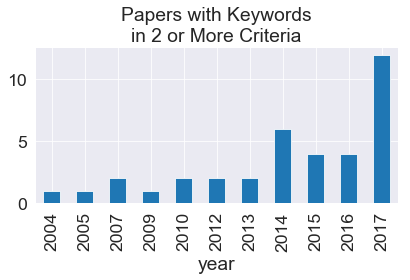

In [23]:
criteria_df = wosis.collate_keyword_criteria_matches(filtered_corpora, crit_matches)
wos_plot.plot_criteria_trend(criteria_df, threshold=2)

In [24]:
criteria_df.count()

abstract              13955
id                    13955
keywords              13955
title                 13955
year                  13955
num_criteria_match    13955
dtype: int64

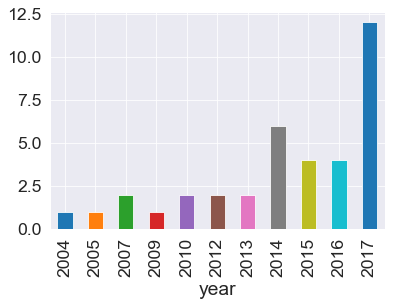

In [25]:
#want to view the papers in the above plot
crit_trend_tmp = criteria_df.loc[criteria_df['num_criteria_match'] > 1, ~criteria_df.columns.isin(hide_columns)]
#criteria_trend.loc[:, criteria_trend.columns.isin(hide_columns)].head(10)


crit_trend_tmp.groupby('year').count()['title'].plot(kind='bar')

In [26]:
crit_trend_tmp['title']

253      Development of early-warning protocol for pred...
1530     Modelling the effects of water diversion and c...
1787     Modeling Nitrogen Dynamics in a Waste Stabiliz...
1804     Effect of Single and Multisite Calibration Tec...
1900     Global Sensitivity Analysis Techniques for Pro...
2189     Sensitivity analysis of reference evapotranspi...
3447     A non-probabilistic methodology for reliable s...
4397     Necessary condition for applying experimental ...
4727     Mortality sensitivity in life-stage simulation...
5171     Practical identifiability and uncertainty anal...
5303     A comparison between the uncertainties in mode...
5393     The use of global sensitivity analysis for imp...
6049     Three complementary methods for sensitivity an...
6103     Prediction of effluent concentration in a wast...
6281     Trends in sensitivity analysis practice in the...
6655     Sensitivity analysis of related parameters in ...
6659     Quantitative global sensitivity analysis of th.

In [27]:
# ?wosis.keyword_matches

In [28]:
lsa_matches = wosis.keyword_matches(filtered_corpora, criteria['LSA'], threshold=95.0)
gsa_matches = wosis.keyword_matches(filtered_corpora, criteria['GSA'], threshold=95.0)
oat_matches = wosis.keyword_matches(filtered_corpora, criteria['OAT'], threshold=95.0)

In [29]:
lsa_collated = lsa_matches.combine_recs()
lsa_df = wosis.rc_to_df(lsa_collated)

gsa_collated = gsa_matches.combine_recs()
gsa_df = wosis.rc_to_df(gsa_collated)

oat_collated = oat_matches.combine_recs()
oat_df = wosis.rc_to_df(oat_collated)

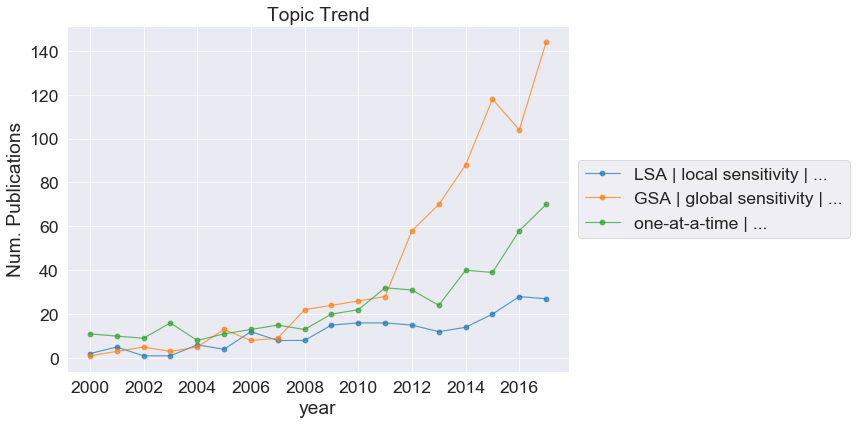

In [30]:
wos_plot.plot_topic_trend([lsa_matches, gsa_matches, oat_matches])